Adapted from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/flow.py
and https://github.com/ritchie46/vanilla-machine-learning

In [68]:
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

In [69]:
%config InlineBackend.figure_format='retina'
sns.set()

In [70]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [71]:
class NormalizingFlow(nn.Module):

    """from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/flow.py"""
    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.flow_length = flow_length

    def forward(self, z):
    
        lj = torch.zeros((self.flow_length, z.shape[0], 1))

        for i in range(self.flow_length):
        
            transform, log_jacobian = self.transforms[i], self.log_jacobians[i]
            lj[i] = log_jacobian(z)
            z = transform(z)

        return z, lj
    
    def sample(self, shape):
        
        z0 = torch.normal(0, 1, size=shape) 
        zk, lj = self(z0)
        return z0, zk, lj
        

class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [72]:
def det_loss(x, z_0, z_k, lj):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function

    # Qz0
    log_qz0 = dist.Normal(0, 1).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - lj.sum()
    # P(x|z)
    nll = -dist.Normal(z_k[0, 0], torch.exp(0.5 * z_k[0, 1])).log_prob(x).sum()
    
    return log_qzk + nll

In [73]:
def train_flow(x, flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
        
            z0, zk, lj = flow.sample(shape=shape)
            loss = det_loss(x=x,
                            z_0=z0,
                            z_k=zk,
                            lj=lj)
            
            loss.backward()
            optim.step()
            optim.zero_grad()
            if i % 100 == 0:
                pbar.set_postfix({'loss': loss.item()})
            pbar.update()

In [74]:
x = np.random.normal(loc=5, scale=2, size=20)

In [75]:
%%time
flow = NormalizingFlow(dim=2, flow_length=16)
shape = (1, 2)
train_flow(torch.from_numpy(x), flow, shape, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 38.7 s, sys: 379 ms, total: 39 s
Wall time: 40 s


In [76]:
def show_samples(s0, sk):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > 0) & (z0.data[:, 1] > 0)
    mask_2 = (z0.data[:, 0] > 0) & (z0.data[:, 1] < 0)
    mask_3 = (z0.data[:, 0] < 0) & (z0.data[:, 1] > 0)
    mask_4 = (z0.data[:, 0] < 0) & (z0.data[:, 1] < 0)
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', '$z_k$']):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)
        
        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        
        # Plot truth
        plt.scatter(5, np.log(2**2), color='black', alpha=1)
        
        plt.show()

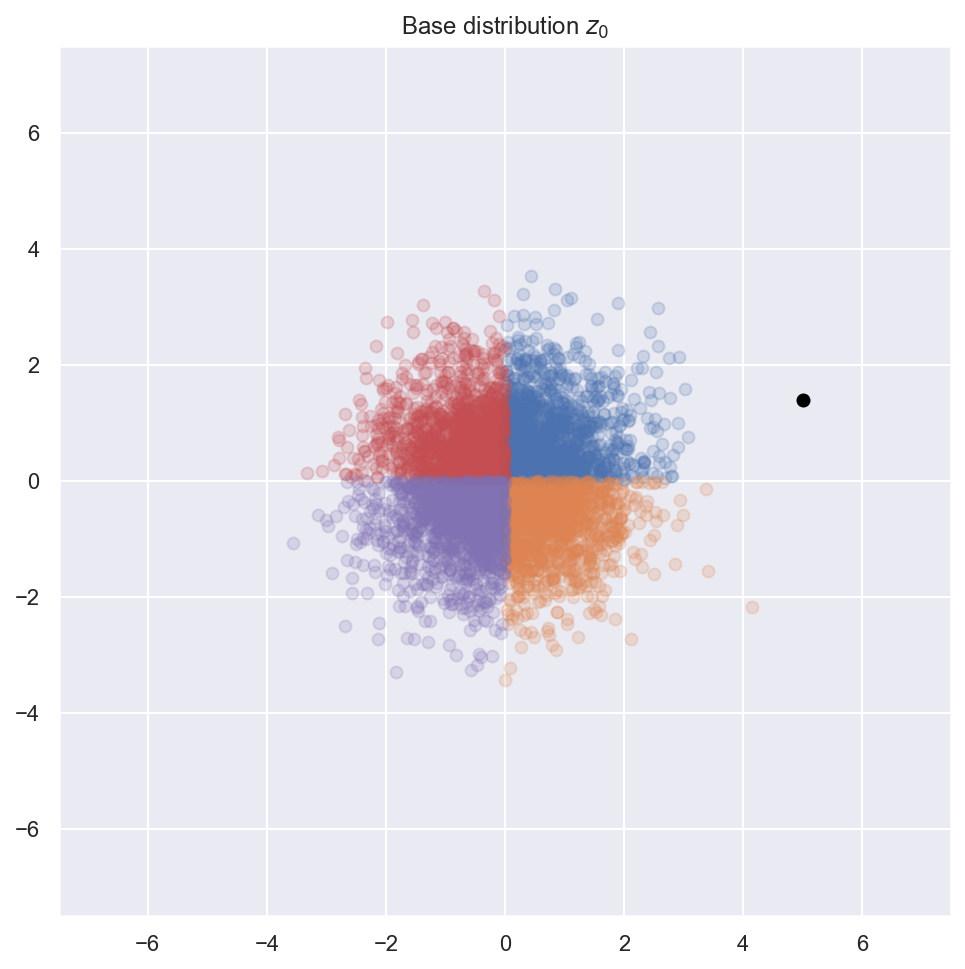

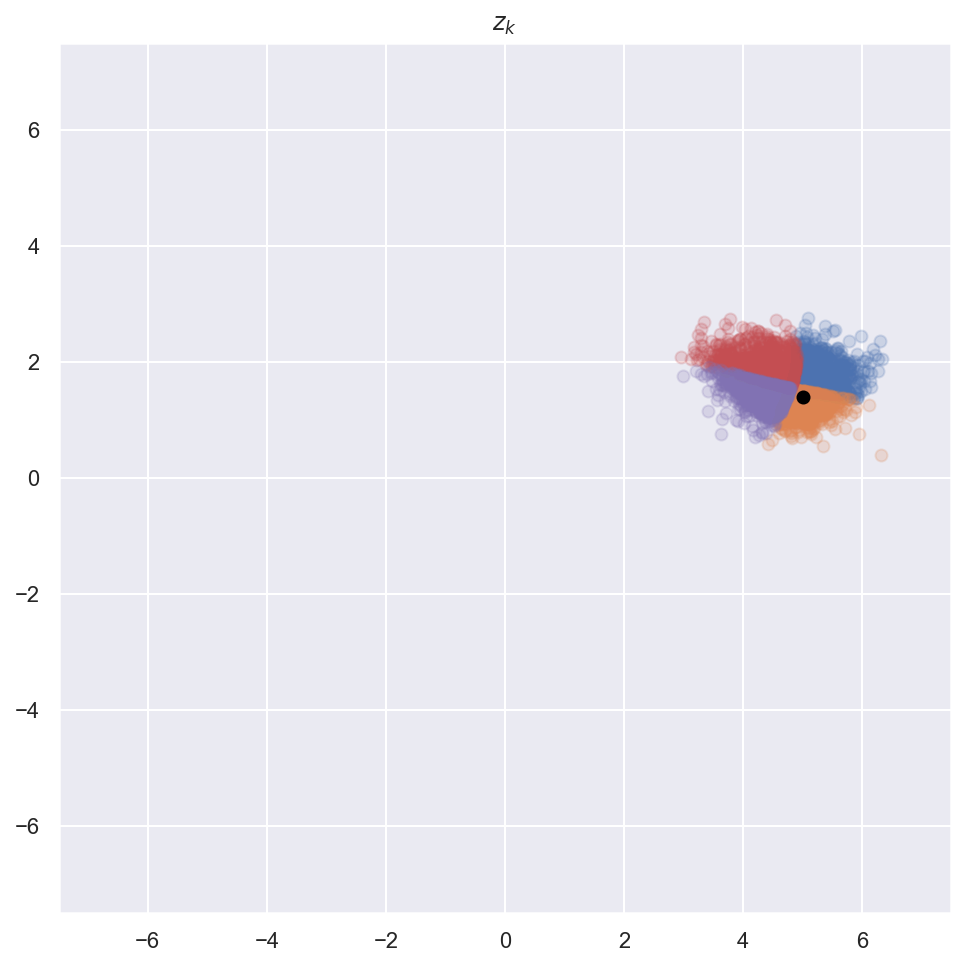

In [77]:
z0, zk, lj = flow.sample((5000, 2))
show_samples(z0.data, zk.data)

In [78]:
zk_mu = np.array(zk.data[:, 0])
zk_std = np.array(zk.data[:, 1])

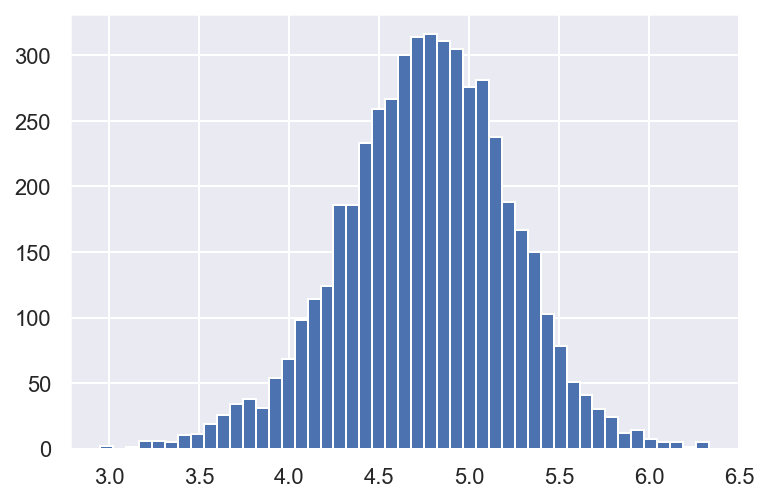

In [79]:
plt.hist(zk_mu, bins='auto');

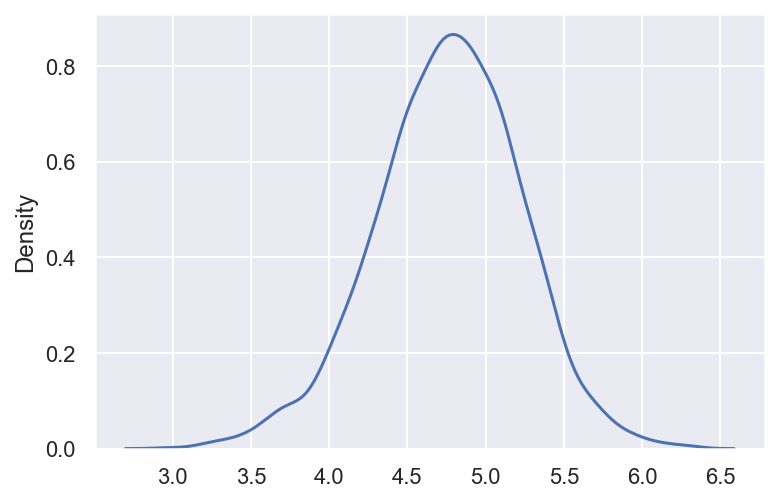

In [80]:
sns.kdeplot(zk_mu);

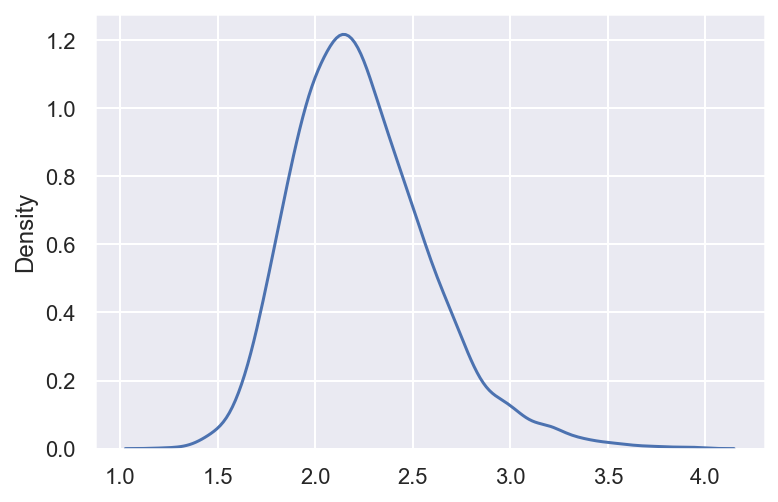

In [81]:
sns.kdeplot(np.exp(0.5*zk_std));